# Importing Libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycaret
import glob
import os
import math
import warnings
import matplotlib
warnings.filterwarnings("ignore")
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=30)
font = {'size'   : 35,
        'weight' : 'bold'}
matplotlib.rc('font', **font)
zone_colours = ["blue","red"]
import lasio
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Loading Tops

In [54]:
tops = pd.read_csv(r".\Tops\Tops.csv").reset_index(drop=True)
tops["DEPTH"] = tops["DEPTH"].astype("float64")

# 15_9-F-11B

In [56]:
_3 = lasio.read(r".\LAS\15_9-F-11B.LAS").df().reset_index()

try:
    try:
        _3["LLD"] = np.log10(_3["LLD"])
    except:
        _3["ILD"] = np.log10(_3["ILD"])
    
except:
    _3["LLD"] = np.log10(_3["RT"])

In [57]:
ranges = tops["DEPTH"].values
tops_names = tops["PICKS"].values
for i in range(len(ranges)):
    if i!=len(ranges)-1:
        s = _3[(_3["DEPTH"]>ranges[i])&(_3["DEPTH"]<ranges[i+1])].index
        _3.loc[s,"Formation"] = tops_names[i]

In [58]:
features = ["GR","LLD","RHOB","NPHI"]

In [59]:
_3 = _3[["DEPTH"]+features+["Formation"]].dropna(how="any").reset_index(drop=True)
_3

,DEPTH,GR,LLD,RHOB,NPHI,Formation
0,3198.2,9.040,0.978865,2.599,0.077,Hod Fm. Top
1,3198.3,9.933,0.977175,2.609,0.071,Hod Fm. Top
2,3198.4,10.037,0.976212,2.609,0.069,Hod Fm. Top
3,3198.5,8.748,0.978226,2.606,0.068,Hod Fm. Top
4,3198.6,9.243,0.974834,2.601,0.067,Hod Fm. Top
...,...,...,...,...,...,...
4088,3607.5,53.260,0.615319,2.347,0.196,Skagerrak Fm. Top
4089,3607.6,51.777,0.616160,2.357,0.193,Skagerrak Fm. Top
4090,3607.7,50.675,0.623042,2.364,0.193,Skagerrak Fm. Top
4091,3607.8,50.126,0.627673,2.367,0.193,Skagerrak Fm. Top


<Figure size 1000x800 with 0 Axes>

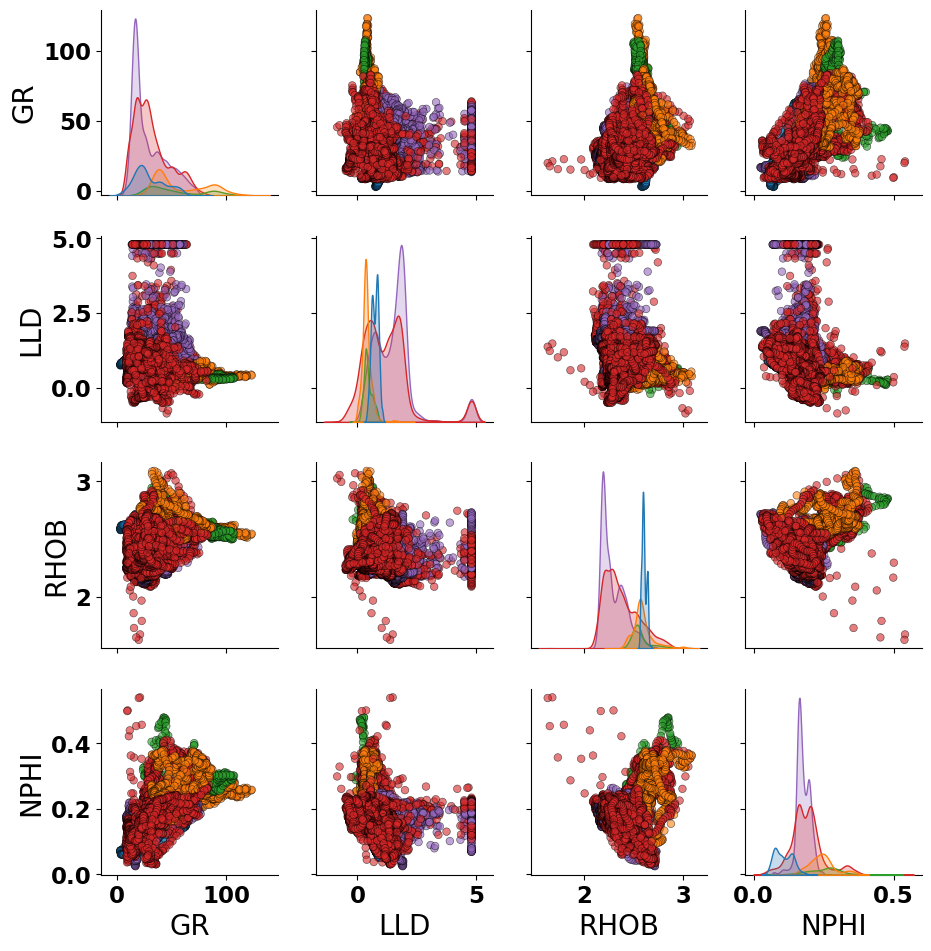

In [32]:
plt.figure(figsize=(10,8))
with sns.plotting_context(rc={'xtick.labelsize': 16.5,'ytick.labelsize': 16.5,'axes.labelsize':20}):
    z = sns.pairplot(_3, vars=features, diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'},hue="Formation")
    z._legend.remove()

<AxesSubplot: >

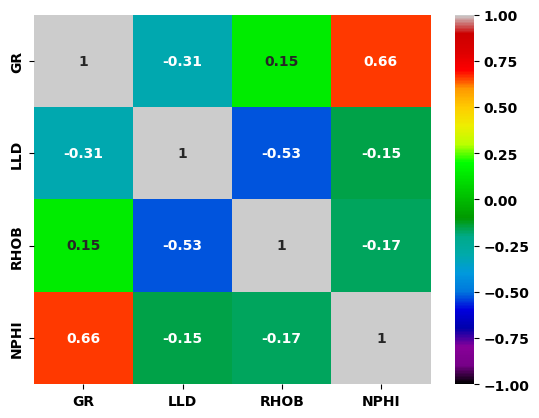

In [60]:
import warnings
warnings.filterwarnings("ignore")
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
font = {'size'   : 8,
        'weight' : 'bold'}
matplotlib.rc('font', **font)
zone_colours = ["blue","red"]
z = sns.heatmap(_3[features].corr(),annot=True,cmap="nipy_spectral",annot_kws={"fontsize":10}, vmin=-1, vmax=1)
z

In [61]:
fest = features
FEAT = fest

A = _3.copy().dropna(how="any").reset_index(drop=True)
a0 = A[fest][np.abs(A[fest] - A[fest].mean()) <= (3 * A[fest].std())]


a1 = pd.DataFrame([],index=A.index)
for i in fest:
    print(i)
    iso = IsolationForest(contamination=0.03)
    yhat = iso.fit_predict(A[[i]])
    mask = yhat != -1
    a1[i]= A[i][mask]
    
    
a2= pd.DataFrame([],index=A.index)
for i in fest:
    ee = EllipticEnvelope(contamination=0.03)
    yhat = ee.fit_predict(A[[i]])
    mask = yhat != -1
    a2[i]= A[i][mask]


a3= pd.DataFrame([],index=A.index)
for i in fest:
    lof = LocalOutlierFactor(contamination=0.2)
    yhat = lof.fit_predict(A[[i]])
    mask = yhat != -1
    a3[i]= A[i][mask]


# # Method 5: One-class SVM

a4= pd.DataFrame([],index=A.index)
for i in fest:

    svm = OneClassSVM(nu=0.03)
    yhat = svm.fit_predict(A[[i]])
    mask = yhat != -1
    a4[i]= A[i][mask]

GR
LLD
RHOB
NPHI


In [40]:
select_algo = a3
select_algo

,GR,LLD,RHOB,NPHI
0,9.040,0.978865,2.599,0.077
1,9.933,0.977175,2.609,0.071
2,10.037,0.976212,2.609,0.069
3,8.748,0.978226,2.606,0.068
4,9.243,NaN,2.601,NaN
...,...,...,...,...
15319,26.995,1.230321,2.688,NaN
15320,NaN,1.216614,2.674,NaN
15321,25.915,1.195678,2.655,NaN
15322,NaN,1.167554,2.632,NaN


Text(0, 0.5, 'DEPTH (feets)')

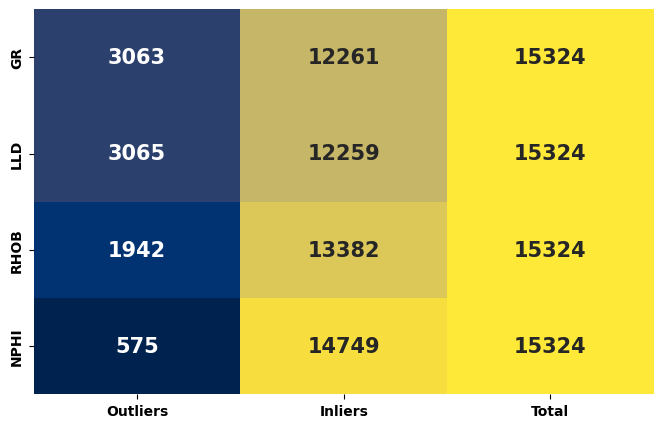

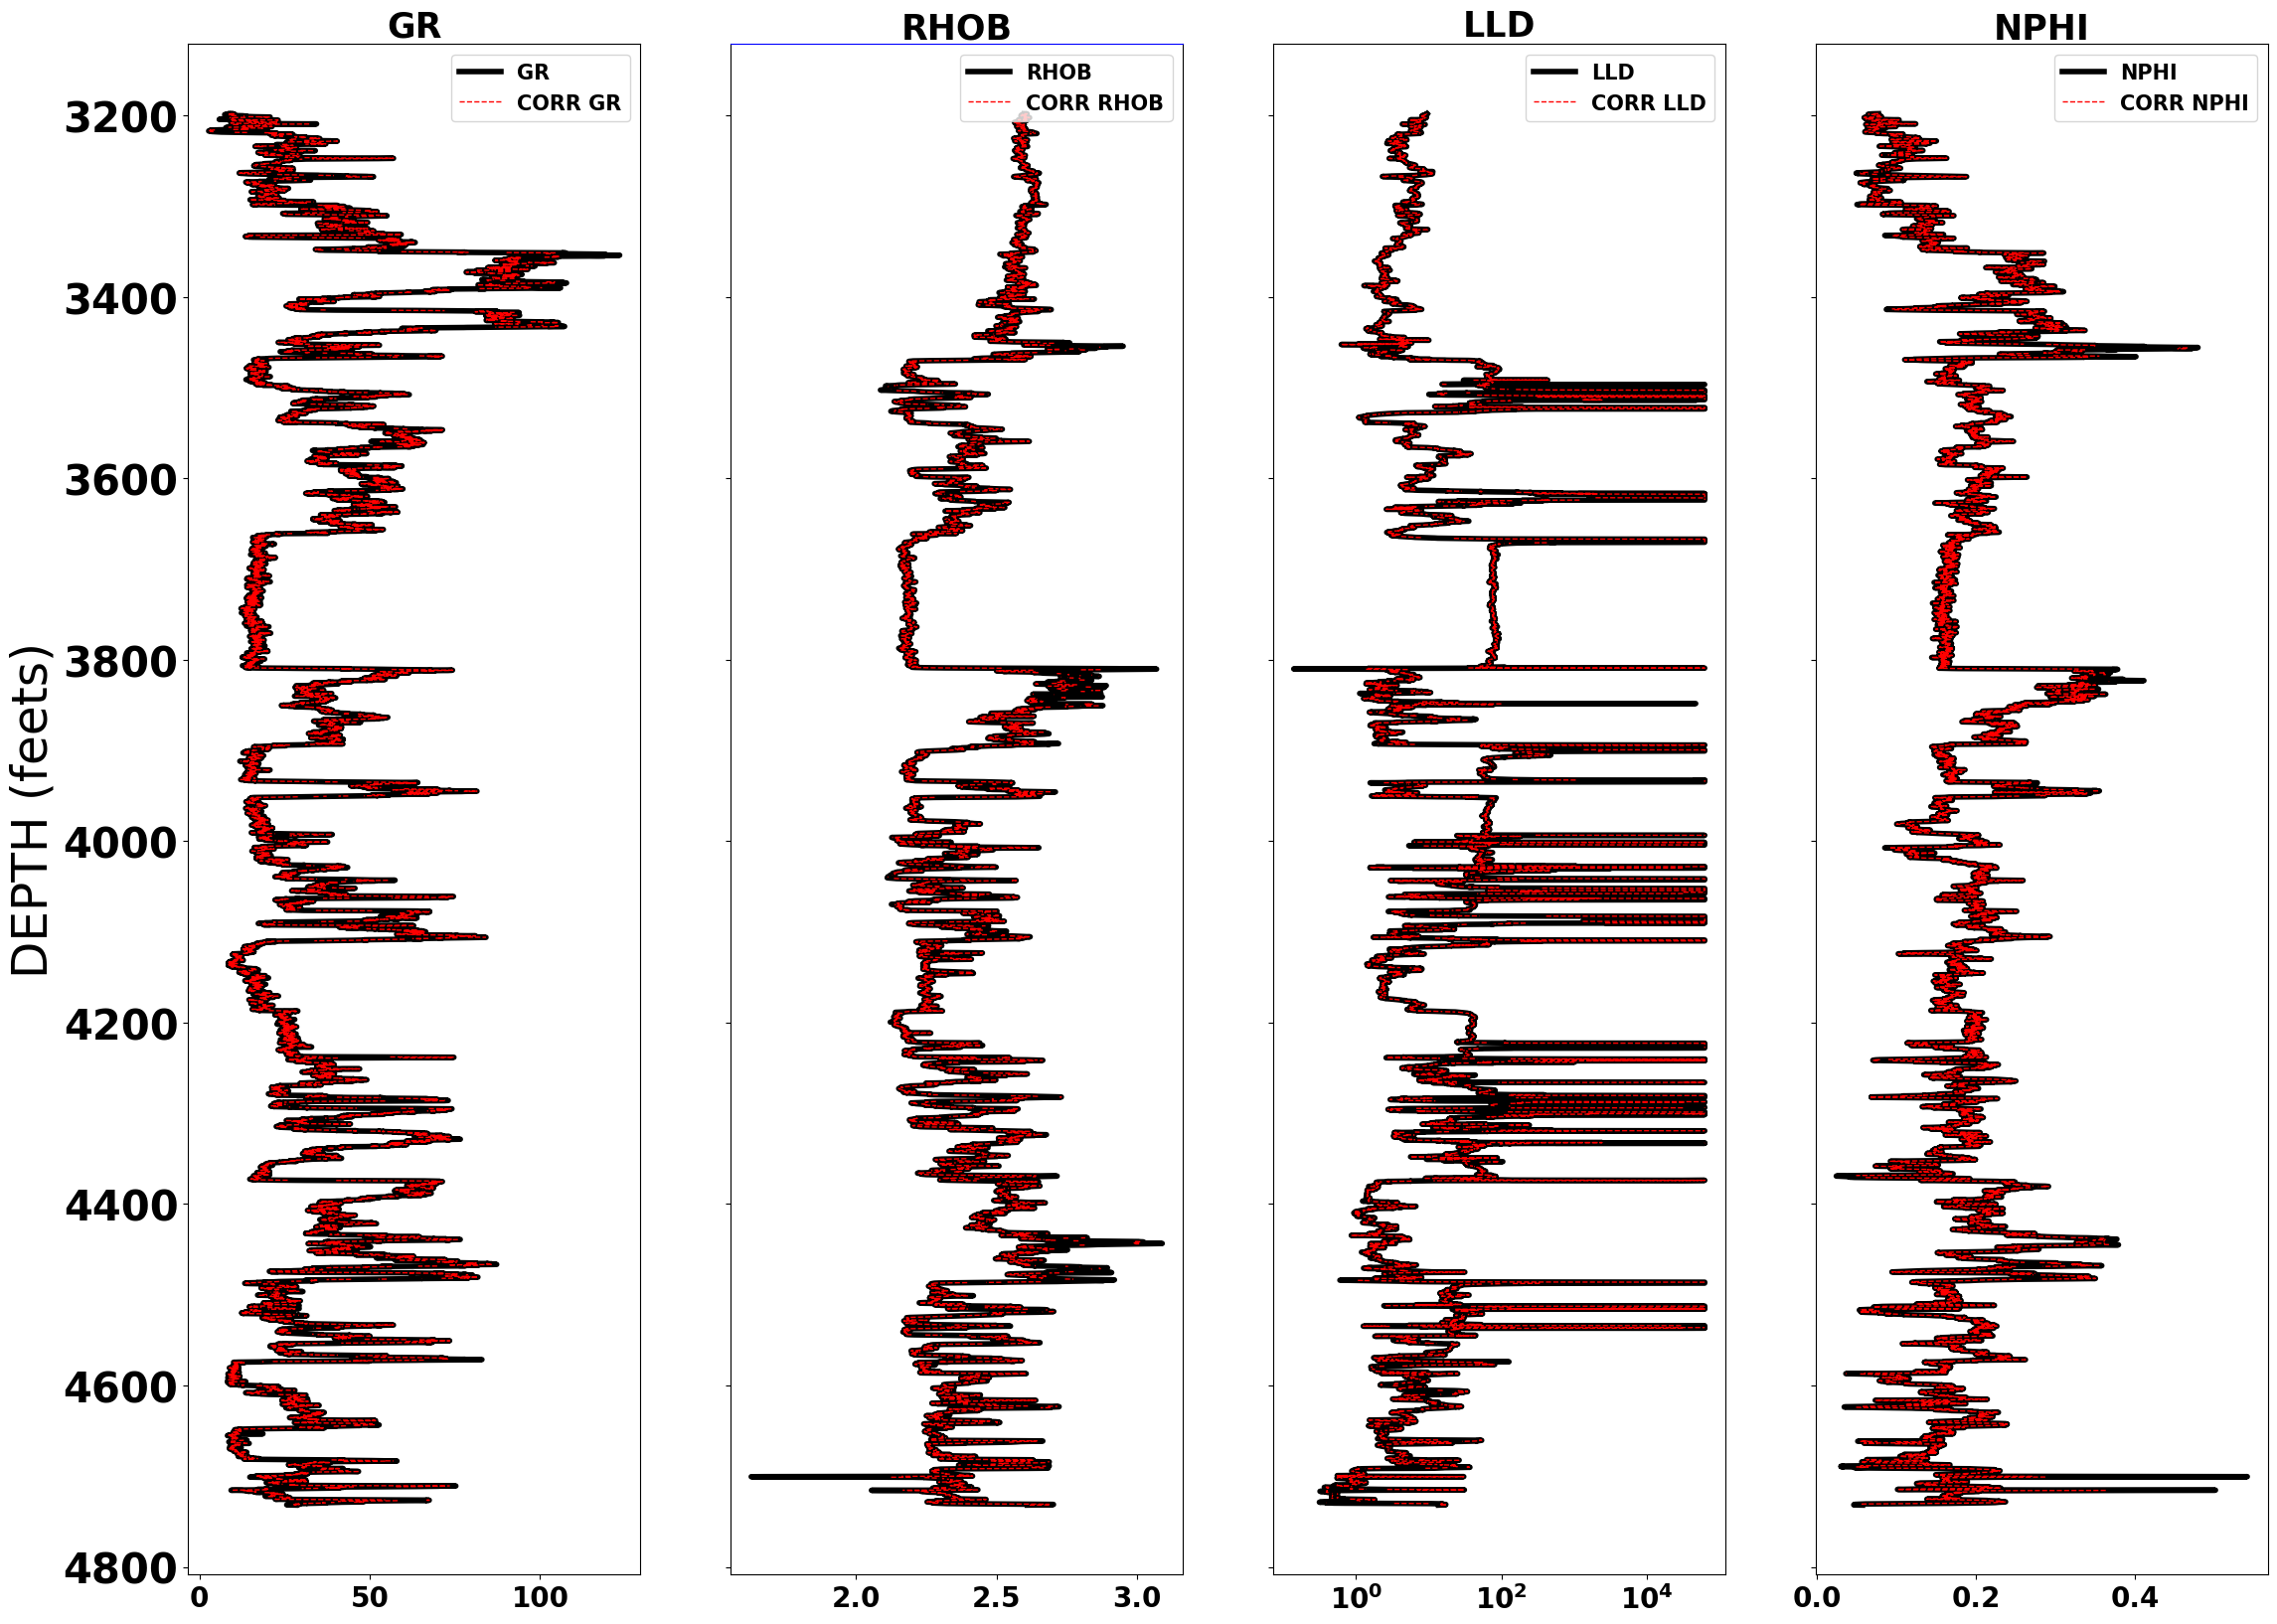

In [41]:
report = pd.DataFrame(select_algo.isnull().sum(),columns=["Outliers"])
report["Inliers"] = select_algo.notnull().sum()
report["Total"] = select_algo.shape[0]
import warnings
warnings.filterwarnings("ignore")
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
font = {'size'   : 15,
        'weight' : 'bold'}
matplotlib.rc('font', **font)
zone_colours = ["blue","red"]
plt.figure(figsize=(8,5))
sns.heatmap(report,annot=True,cbar=False, fmt='g',cmap="cividis")
names=[]
for i in features:
    names.append("CORR " + i)
indexing = select_algo.index
new = pd.DataFrame(np.array(select_algo),columns=names,index=indexing )
new = pd.concat([_3,new],axis=1)
a=new.copy()
a["LLD"] = 10**a["LLD"]
a["CORR LLD"] = 10**a["CORR LLD"]
import matplotlib
warnings.filterwarnings("ignore")
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=30)
font = {'size'   : 35,
        'weight' : 'bold'}
matplotlib.rc('font', **font)
plotting = ["GR","RHOB","LLD","NPHI"]
fig,ax = plt.subplots(nrows=1,ncols=len(plotting),figsize=(27,20),sharey=True)
fig.subplots_adjust(wspace=0.2)
for j,i in enumerate(plotting):
    if i=="RHOB":
        ax[j].plot(a[i],a["DEPTH"],label="RHOB",linewidth=4,color="black")
        ax[j].plot(a["CORR RHOB"],a["DEPTH"],color="red",linewidth=1,linestyle="--",label="CORR RHOB")
        ax[j].spines["top"].set_position(("axes", 1))

        ax[j].spines["top"].set_visible(True)
        ax[j].spines["top"].set_edgecolor("blue")
        ax[j].set_xlabel("RHOB",fontdict={"fontsize":25,"fontweight":'bold'})
        ax[j].xaxis.set_label_position("top")
        ax[j].legend(loc=1,fontsize=15)
    elif i=="LLD":
        ax[j].semilogx(a[i],a["DEPTH"],label="LLD",linewidth=4,color="black")
        ax[j].semilogx(a["CORR LLD"],a["DEPTH"],color="red",linewidth=1,linestyle="--",label="CORR LLD")
        ax[j].set_title(i,fontdict={"fontsize":25,"fontweight":'bold'})
        ax[j].legend(loc=1,fontsize=15)
    elif i=="GR":
        ax[j].plot(a["GR"],a["DEPTH"],color="black",label="GR",linewidth=4)
        ax[j].plot(a["CORR GR"],a["DEPTH"],color="red",label="CORR GR",linewidth=1,linestyle="--")
        ax[j].set_title(i,fontdict={"fontsize":25,"fontweight":'bold'})
        ax[j].legend(loc=1,fontsize=15)
        ax[j].grid(False)
    elif i=="CALI":
        ax[j].plot(a["CALI"],a["DEPTH"],color="red",label="CALI")
        ax[j].set_title(i,fontdict={"fontsize":25,"fontweight":'bold'})
        ax[j].legend(loc=1,fontsize=15)
    elif i=="DT":
        ax[j].plot(a[i],a["DEPTH"],color="black",label="GR",linewidth=4)
        ax[j].plot(a["CORR DT"],a["DEPTH"],color="red",label="CORR DT",linewidth=1,linestyle="--")
        ax[j].spines["top"].set_position(("axes", 1))

        ax[j].spines["top"].set_visible(True)
        ax[j].set_xlabel("DT",fontdict={"fontsize":25,"fontweight":'bold'})
        ax[j].xaxis.set_label_position("top")
        ax[j].legend(loc=1,fontsize=15)

    elif i=="NPHI":
        ax[j].plot(a[i],a["DEPTH"],label="NPHI",linewidth=4,color="black")
        ax[j].plot(a["CORR NPHI"],a["DEPTH"],color="red",label="CORR NPHI",linewidth=1,linestyle="--")
        ax[j].spines["top"].set_position(("axes", 1))
        ax[j].spines["top"].set_visible(True)
        ax[j].set_xlabel("NPHI",fontdict={"fontsize":25,"fontweight":'bold'})
        ax[j].xaxis.set_label_position("top")
        ax[j].legend(loc=1,fontsize=15)

    elif (i!="Formation")&(i!="crossover"):
        ax[j].plot(a[i],a["DEPTH"])
        ax[j].set_xticks([])
        ax[j].set_title(i,fontdict={"fontsize":25,"fontweight":'bold'})
        ax[j].legend(loc=1,fontsize=15)

ax[0].invert_yaxis()
ax[0].set_ylabel("DEPTH (feets)")



In [62]:
a = new.copy()
a

,DEPTH,GR,LLD,RHOB,NPHI,Formation,CORR GR,CORR LLD,CORR RHOB,CORR NPHI
0,3198.2,9.040,0.978865,2.599,0.077,Hod Fm. Top,9.040,0.978865,2.599,0.077
1,3198.3,9.933,0.977175,2.609,0.071,Hod Fm. Top,9.933,0.977175,2.609,0.071
2,3198.4,10.037,0.976212,2.609,0.069,Hod Fm. Top,10.037,0.976212,2.609,0.069
3,3198.5,8.748,0.978226,2.606,0.068,Hod Fm. Top,8.748,0.978226,2.606,0.068
4,3198.6,9.243,0.974834,2.601,0.067,Hod Fm. Top,9.243,NaN,2.601,NaN
...,...,...,...,...,...,...,...,...,...,...
15319,4731.5,26.995,1.230321,2.688,0.046,Hugin Fm. VOLVE Top,26.995,1.230321,2.688,NaN
15320,4731.6,25.603,1.216614,2.674,0.046,Hugin Fm. VOLVE Top,NaN,1.216614,2.674,NaN
15321,4731.7,25.915,1.195678,2.655,0.048,Hugin Fm. VOLVE Top,25.915,1.195678,2.655,NaN
15322,4731.8,27.293,1.167554,2.632,0.051,Hugin Fm. VOLVE Top,NaN,1.167554,2.632,NaN


Number of points before outliers removed                       : 15324
Number of points after outliers removed with Standard Deviation: 4093
Number of points after outliers removed with Isolation Forest  : 4093
Number of points after outliers removed with Min. Covariance   : 4093
Number of points after outliers removed with Outlier Factor    : 4093
Number of points after outliers removed with One-class SVM     : 4093


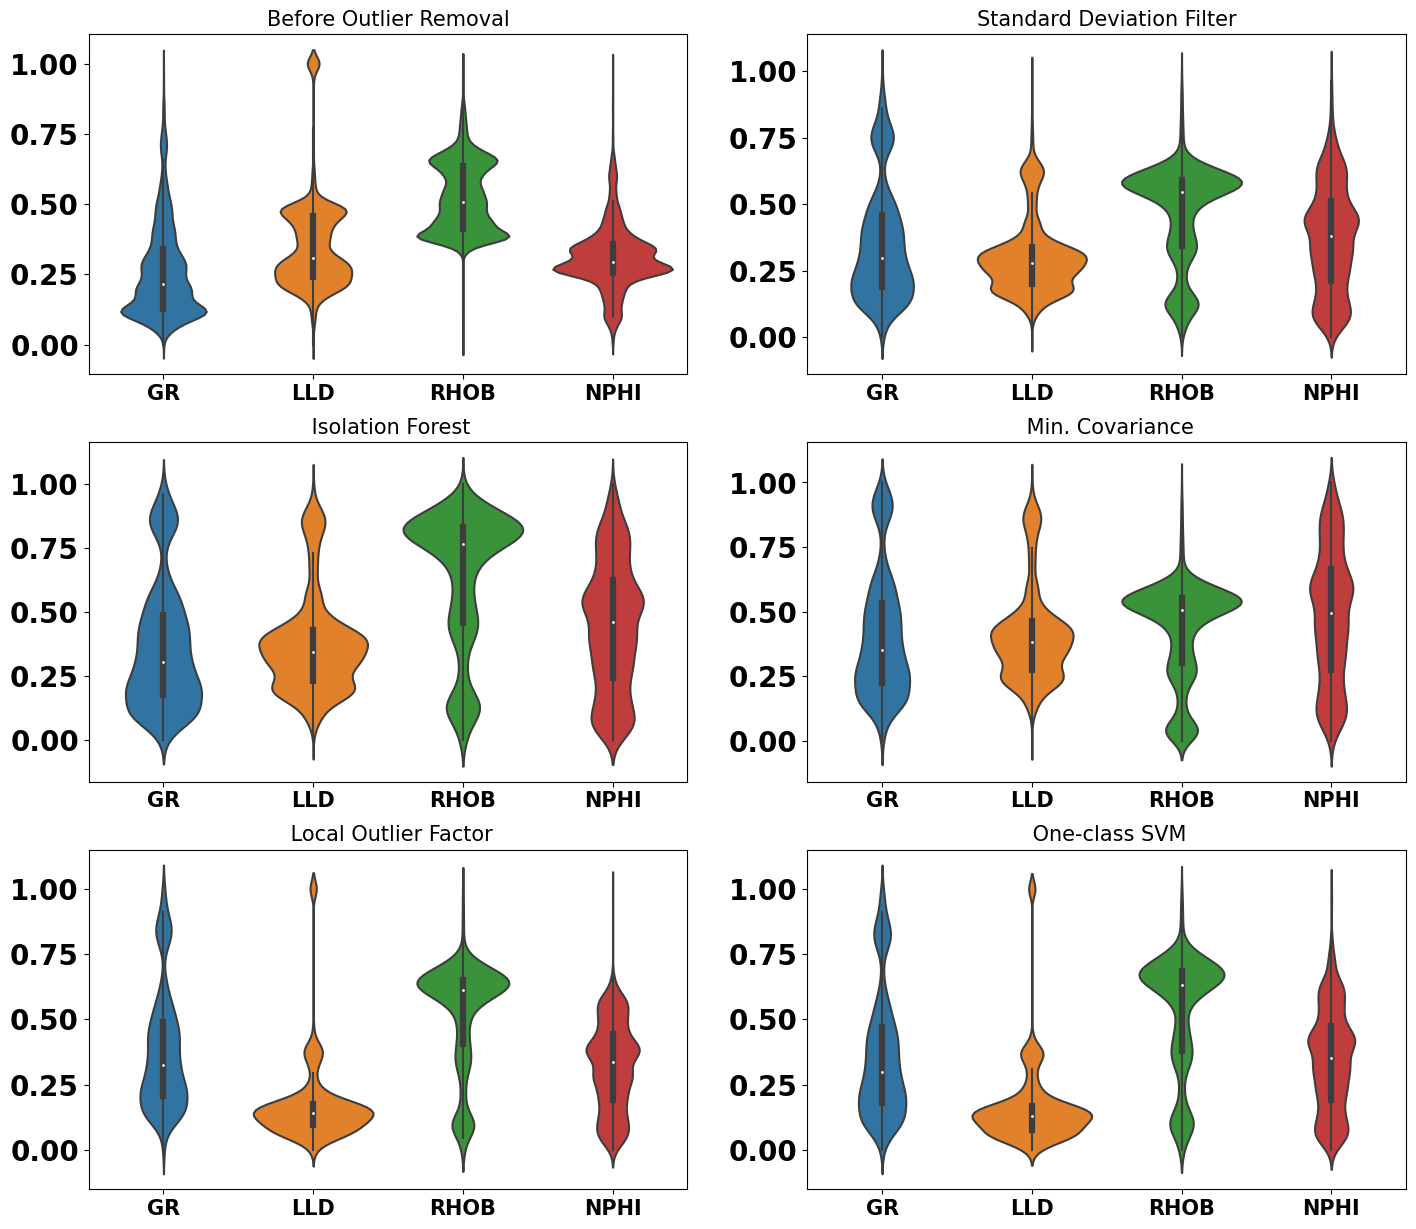

In [63]:
import matplotlib
warnings.filterwarnings("ignore")
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=20)
font = {'size'   : 35,
        'weight' : 'bold'}
matplotlib.rc('font', **font)
from sklearn.preprocessing import MinMaxScaler
print('Number of points before outliers removed                       :', len(a))
print('Number of points after outliers removed with Standard Deviation:', len(a0))
print('Number of points after outliers removed with Isolation Forest  :', len(a1))
print('Number of points after outliers removed with Min. Covariance   :', len(a2))
print('Number of points after outliers removed with Outlier Factor    :', len(a3))
print('Number of points after outliers removed with One-class SVM     :', len(a4))

plt.figure(figsize=(17,15))

plt.subplot(3,2,1)
scaler = MinMaxScaler().fit(a[fest])
sns.violinplot(data=pd.DataFrame(scaler.transform(a[fest]),columns=fest))

plt.title('Before Outlier Removal', size=15)

plt.subplot(3,2,2)
scaler = MinMaxScaler().fit(a0[fest])
sns.violinplot(data=pd.DataFrame(scaler.transform(a0[fest]),columns=fest))
plt.title('Standard Deviation Filter', size=15)

plt.subplot(3,2,3)
scaler = MinMaxScaler().fit(a1[fest])
sns.violinplot(data=pd.DataFrame(scaler.transform(a1[fest]),columns=fest))
plt.title(' Isolation Forest', size=15)

plt.subplot(3,2,4)
scaler = MinMaxScaler().fit(a2[fest])
sns.violinplot(data=pd.DataFrame(scaler.transform(a2[fest]),columns=fest))
plt.title(' Min. Covariance', size=15)

plt.subplot(3,2,5)
scaler = MinMaxScaler().fit(a3[fest])
sns.violinplot(data=pd.DataFrame(scaler.transform(a3[fest]),columns=fest))
plt.title(' Local Outlier Factor', size=15)

plt.subplot(3,2,6)
scaler = MinMaxScaler().fit(a4[fest])
sns.violinplot(data=pd.DataFrame(scaler.transform(a4[fest]),columns=fest))
plt.title(' One-class SVM', size=15)

plt.show()

# Outlier Removal

<Figure size 1000x800 with 0 Axes>

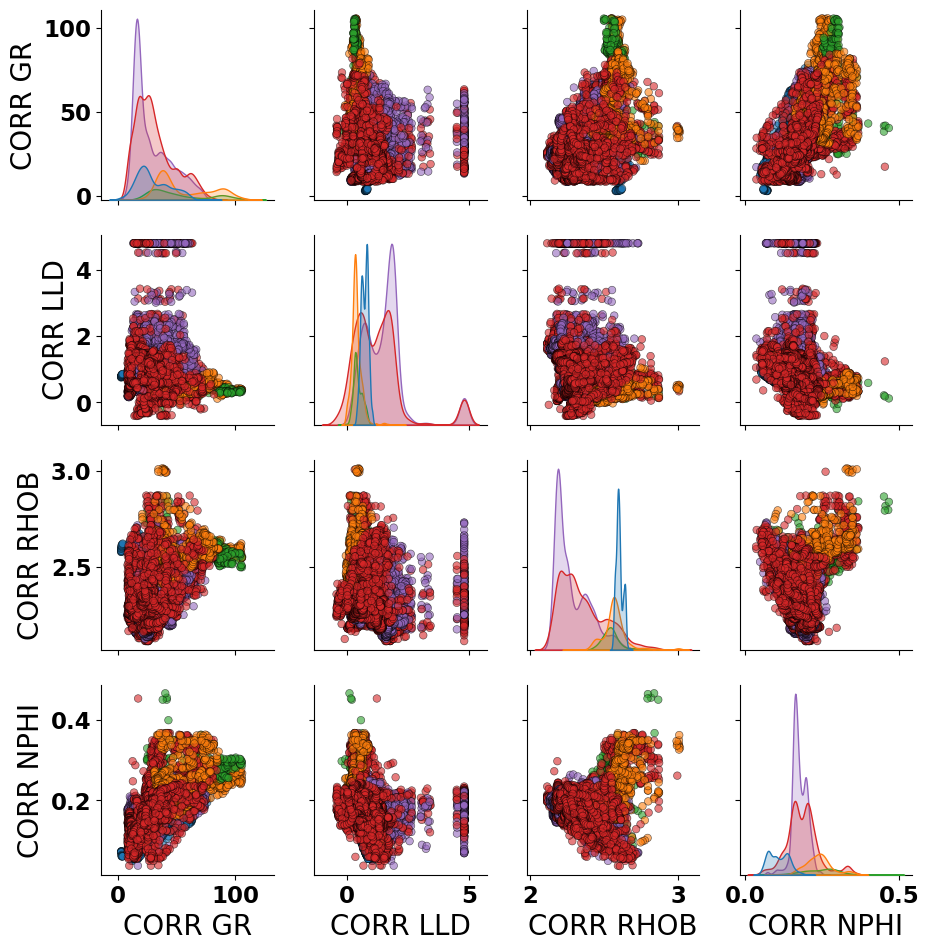

In [44]:
plt.figure(figsize=(10,8))
with sns.plotting_context(rc={'xtick.labelsize': 16.5,'ytick.labelsize': 16.5,'axes.labelsize':20}):
    z = sns.pairplot(new, vars=names, diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'},hue="Formation",)
    z._legend.remove()

In [64]:
a.to_csv(r".\QC\Well_15_9-F-11B.csv",index=False)